This notebook is from https://www.kaggle.com/artgor/eda-and-models-score-0-74291

In [0]:
from google.colab import drive
drive.mount('/content/drive')

#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Check
- id - id of the creature
- bone_length - average length of bone in the creature, normalized between 0 and 1
- rotting_flesh - percentage of rotting flesh in the creature
- hair_length - average hair length, normalized between 0 and 1
- has_soul - percentage of soul in the creature
- color - dominant color of the creature: 'white','black','clear','blue','green','blood'
- type - target variable: 'Ghost', 'Goblin', and 'Ghoul'

In [0]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Kaggle_data/ghouls/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Kaggle_data/ghouls/test.csv')

In [0]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [0]:
test.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


In [0]:
train.describe(include='all')

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
count,371.000000,371.000000,371.000000,371.000000,371.000000,371,371
unique,NaN,NaN,NaN,NaN,NaN,6,3
top,NaN,NaN,NaN,NaN,NaN,white,Ghoul
freq,NaN,NaN,NaN,NaN,NaN,137,129
mean,443.676550,0.434160,0.506848,0.529114,0.471392,NaN,NaN
std,263.222489,0.132833,0.146358,0.169902,0.176129,NaN,NaN
min,0.000000,0.061032,0.095687,0.134600,0.009402,NaN,NaN
25%,205.500000,0.340006,0.414812,0.407428,0.348002,NaN,NaN
50%,458.000000,0.434891,0.501552,0.538642,0.466372,NaN,NaN
75%,678.500000,0.517223,0.603977,0.647244,0.600610,NaN,NaN


In [0]:
for i in [train,test]:
  print(i.isnull().sum())

# there are not NA

id               0
bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
type             0
dtype: int64
id               0
bone_length      0
rotting_flesh    0
hair_length      0
has_soul         0
color            0
dtype: int64


In [0]:
#train.describe(include='all')
train.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


In [0]:
# Drop Id
train_id = train['id']
test_id = test['id']
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

## Continuous data

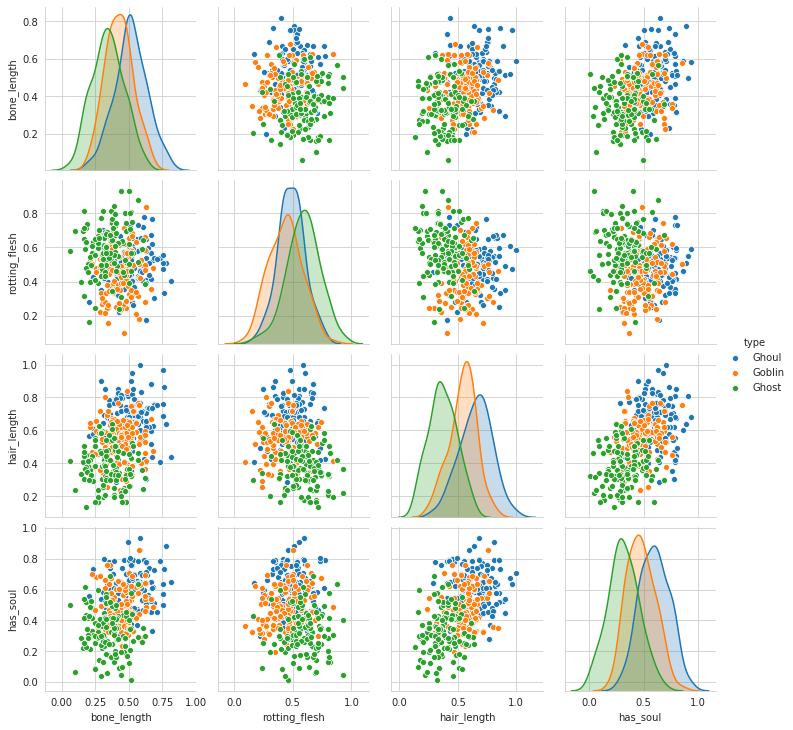

In [0]:
sns.pairplot(train,hue="type")

**pairplot은 데이터가 정규성을 띄고 있는지 확인하기 유용하다. 또한 몇몇 데이터들 끼리 type에 대한 군집을 보여준다.** 이것을 통해 변수들 간의 곱셈을 통해 새로운 파생변수를 만들면 좋을 것이다.

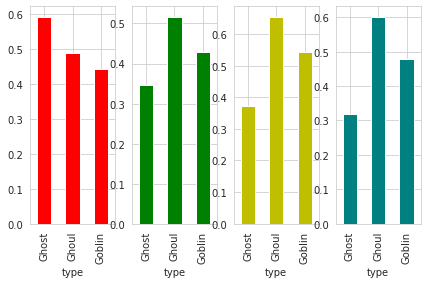

In [0]:
plt.subplot(1,4,1)
train.groupby('type').mean()['rotting_flesh'].plot(kind='bar',figsize=(7,4), color='r')
plt.subplot(1,4,2)
train.groupby('type').mean()['bone_length'].plot(kind='bar',figsize=(7,4), color='g')
plt.subplot(1,4,3)
train.groupby('type').mean()['hair_length'].plot(kind='bar',figsize=(7,4), color='y')
plt.subplot(1,4,4)
train.groupby('type').mean()['has_soul'].plot(kind='bar',figsize=(7,4), color='teal')

연속형 데이터는 'type'별로 대부분 차이가 나타나는 것으로 보임.

## Categorical Data

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3678: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


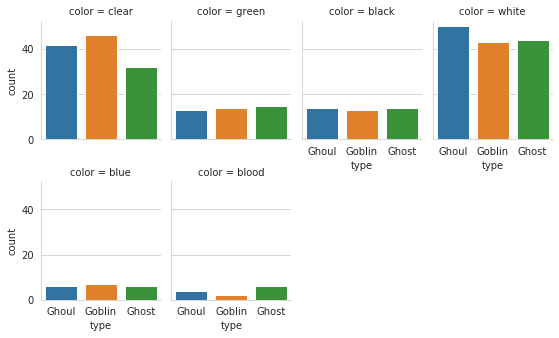

In [0]:
sns.factorplot("type", col="color", col_wrap=4, data=train, kind="count", size=2.4, aspect=.8)

**factorplot은 범주형 데이터끼리 비교할 때 상당히 유용한 것**  같으니 기억해 두자.

seaborn페이지에도 언급되어 있지 않음.

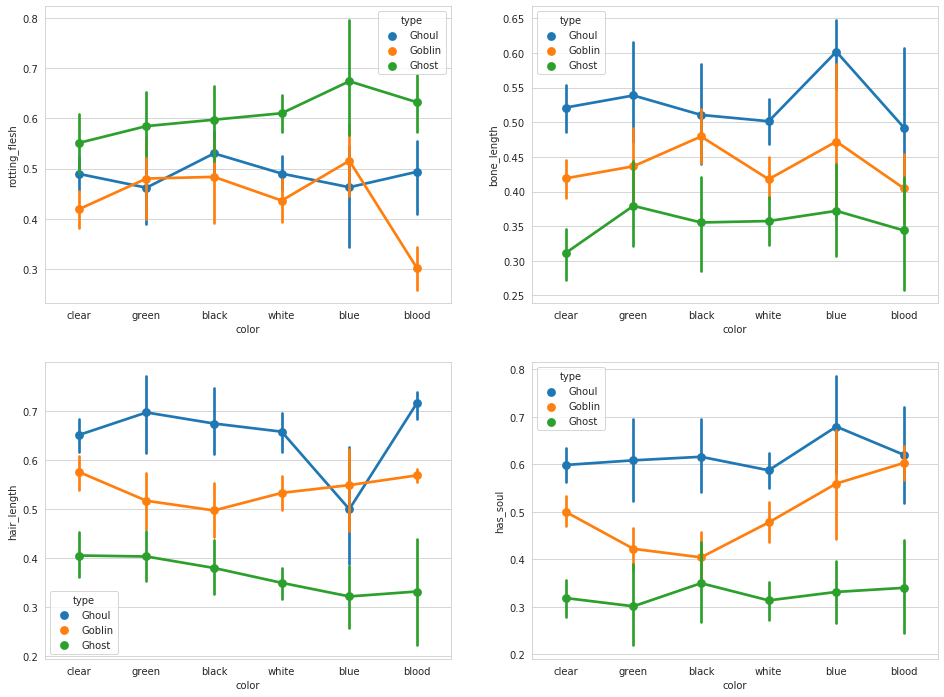

In [0]:
#The graphs look much better with higher figsize.
fig, ax = plt.subplots(2, 2, figsize = (16, 12))
sns.pointplot(x="color", y="rotting_flesh", hue="type", data=train, ax = ax[0, 0])
sns.pointplot(x="color", y="bone_length", hue="type", data=train, ax = ax[0, 1])
sns.pointplot(x="color", y="hair_length", hue="type", data=train, ax = ax[1, 0])
sns.pointplot(x="color", y="has_soul", hue="type", data=train, ax = ax[1, 1])

그래프에서 볼 수 있듯이, 'color'변수는 type을 분리하는데 크게 도움이 되지 않을 것 같다. 'clear'과 'white' 색깔 말고는 크게 차이가 없기 때문이다.

# Data Processing
- Color 변수는 도움이 되지 않아 삭제를 하자.
- 연속형 변수들의 산포도에서 군집 분류가 잘 이루어지는 변수들끼리 곱셈을 하자.

## Data Preparation

- 변수간의 곱

In [0]:
train['hair_soul'] = train['hair_length'] * train['has_soul']
train['hair_bone'] = train['hair_length'] * train['bone_length']
test['hair_soul'] = test['hair_length'] * test['has_soul']
test['hair_bone'] = test['hair_length'] * test['bone_length']
train['hair_soul_bone'] = train['hair_length'] * train['has_soul'] * train['bone_length']
test['hair_soul_bone'] = test['hair_length'] * test['has_soul'] * test['bone_length']

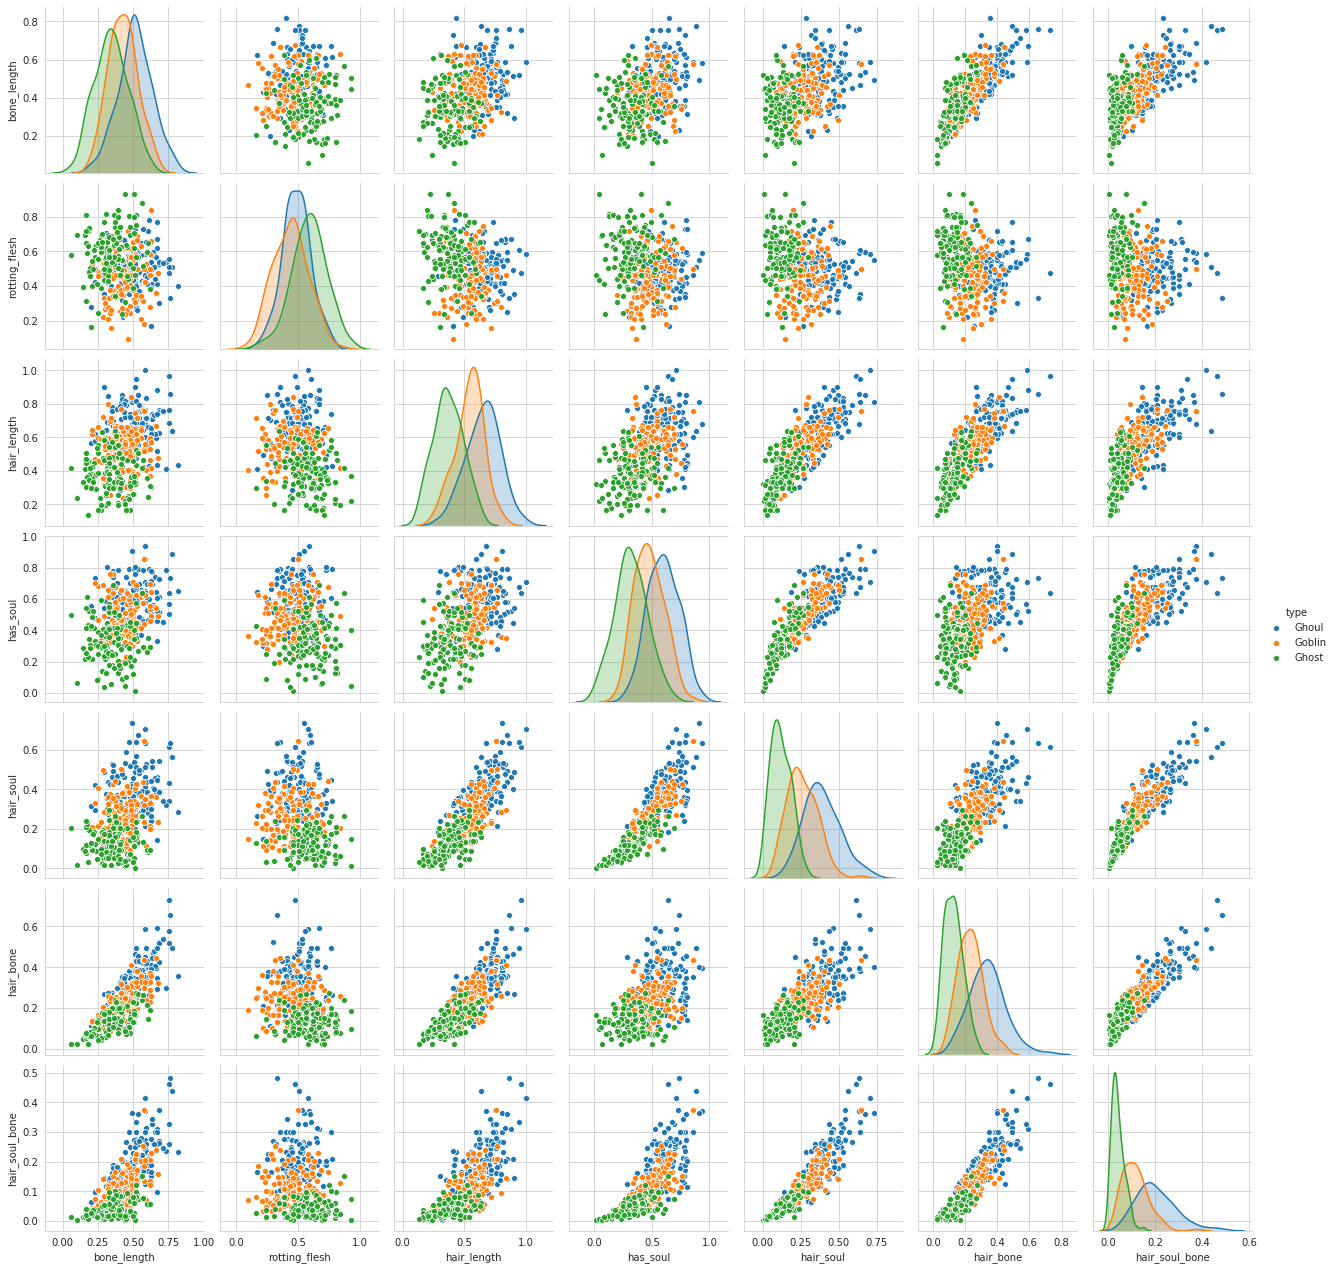

In [0]:
sns.pairplot(train,hue='type')

- 더미변수 만들기
 - DataFrame.add_prefix(넣을 명칭) : 각 컬럼 이름 앞에 이름추가
 - DataFrame.join(데이터 프레임): DataFrame에 데이터 프레임 '열 삽입'

In [0]:
col = 'color'
dummies = pd.get_dummies(train[col], drop_first=False)
dummies = dummies.add_prefix("{}#".format(col))
train.drop(col, axis=1, inplace=True)
train = train.join(dummies)
dummies = pd.get_dummies(test[col], drop_first=False)
dummies = dummies.add_prefix("{}#".format(col))
test.drop(col, axis=1, inplace=True)
test = test.join(dummies)

---

In [0]:
X_train = train.drop('type', axis=1)
le = LabelEncoder()
y_train = le.fit_transform(train.type.values)
X_test = test

## 랜덤 포레스트의 특성 중요도 사용
- 랜덤 포레스트에서 두 개 이상의 특성이 매우 상관관계가 높다면 하나의 특성은 매우 높은 순위를 갖지만 다른 특성 정보는 완전히 잡아내지 못하는 경우가 있다.
 - 특성 중요도 값을 해석하는 것보다 모델의 예측 성능에만 관심이 있다면 크게 신경쓰지 않아도 됨.

 1)hair_soul_bone                 0.188566
 2)hair_soul                      0.177406
 3)hair_bone                      0.148103
 4)hair_length                    0.122035
 5)has_soul                       0.119305
 6)rotting_flesh                  0.118140
 7)bone_length                    0.084821
 8)color#clear                    0.009517
 9)color#white                    0.009374
10)color#green                    0.007276
11)color#blue                     0.006799
12)color#black                    0.006448
13)color#blood                    0.002211


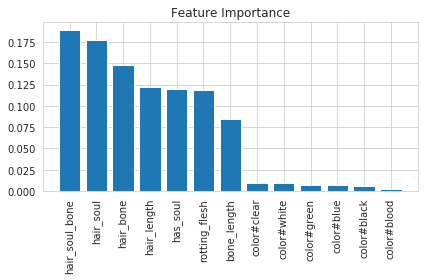

In [0]:
feat_labels= X_train.columns[:]

clf = RandomForestClassifier(n_estimators=500,
                             random_state=1)
clf.fit(X_train,y_train)
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print('%2d)%-*s %f' %(f+1,30,
                        feat_labels[indices[f]],
                        importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
              importances[indices],
              align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices],rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.show()

In [0]:
best_features = X_train.columns[indices[0:7]]
X = X_train[best_features]
Xt = X_test[best_features]

In [0]:
#Splitting data for validation
X_train,X_test,y_train,y_test = train_test_split(X,y_train,
                                                 test_size=0.2,random_state=36)

# Modeling

In [0]:
forest = RandomForestClassifier()
parameter_grid = {'n_estimators' : [10, 20, 100, 150],
                  'criterion' : ['gini', 'entropy'],
                  'max_features' : ['auto', 'sqrt', 'log2', None],
                  'max_depth' : [None, 5, 20, 100],
                  'min_samples_split' : [2, 5, 7],
                  'min_weight_fraction_leaf' : [0.0, 0.1],
                  'max_leaf_nodes' : [40, 60, 80]
                 }

grid_search = GridSearchCV(forest, param_grid=parameter_grid,
                           scoring='accuracy',
                           cv=StratifiedKFold(5))
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7734463276836159
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': 80, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.1, 'n_estimators': 10}


In [0]:
#The last model is logistic regression
logreg = LogisticRegression()

parameter_grid = {'solver' : ['liblinear','newton-cg'], # 'lbfgs'
                  'multi_class' : ['auto'],
                  'C' : [0.005, 0.01, 1, 10, 100, 1000],
                  'tol': [0.0001, 0.001, 0.005]
                 }

grid_search = GridSearchCV(logreg, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.756497175141243
Best parameters: {'C': 1, 'multi_class': 'auto', 'solver': 'newton-cg', 'tol': 0.005}
